# Object detection: Added snow

We compared the performance of models from FaceBook's Detectron project and YOLOv3 model from Joseph Redmon, when different error sources were added. The models from FaceBook's Detectron project were FasterRCNN, MaskRCNN and RetinaNet.

In [1]:
import re
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
from PIL import Image

from dpemu import runner
from dpemu.dataset_utils import load_coco_val_2017
from dpemu.filters.image import Snow
from dpemu.ml_utils import run_ml_module_using_cli, load_yolov3
from dpemu.nodes import Array, Series
from dpemu.plotting_utils import print_results_by_model, visualize_scores
from dpemu.utils import get_project_root

We used 118 287 jpg images (COCO train2017) as the train set and 5000 images (COCO val2017) as the test set to calculate the mAP-50 scores.

In [2]:
def get_data():
    imgs, _, _, img_filenames = load_coco_val_2017()
    return imgs, img_filenames

In [3]:
def get_err_root_node():
    err_node = Array()
    err_root_node = Series(err_node)
    err_node.addfilter(Snow("snowflake_probability", "snowflake_alpha", "snowstorm_alpha"))
    return err_root_node

## Examples from run_yolo_example.py

### snowflake_probability: 0.0001

![](imgs/20190830-000610-408561.jpg)

### snowflake_probability: 0.001

![](imgs/20190830-000613-442625.jpg)

### snowflake_probability: 0.01

![](imgs/20190830-000616-476388.jpg)

### snowflake_probability: 0.1

![](imgs/20190830-000620-661563.jpg)

In [4]:
def get_err_params_list():
    return [{"snowflake_probability": p, "snowflake_alpha": .4, "snowstorm_alpha": 0}
            for p in [10 ** i for i in range(-4, 0)]]

In [5]:
class Preprocessor:

    def run(self, _, imgs, params):
        img_filenames = params["img_filenames"]

        for i, img_arr in enumerate(imgs):
            img = Image.fromarray(img_arr)
            path_to_img = f"{get_project_root()}/tmp/val2017/" + img_filenames[i]
            img.save(path_to_img, "jpeg", quality=100)

        return None, imgs, {}

Detectron's model zoo had pretrained weights for FasterRCNN, MaskRCNN and RetinaNet. YOLOv3's weights were trained by us, using the Kale cluster of University of Helsinki. The training took approximately five days when two NVIDIA Tesla V100 GPUs were used.

In [6]:
class YOLOv3Model:

    def run(self, _, imgs, params):
        path_to_yolov3_weights, path_to_yolov3_cfg = load_yolov3()

        cline = f"{get_project_root()}/libs/darknet/darknet detector map {get_project_root()}/data/coco.data \
            {path_to_yolov3_cfg} {path_to_yolov3_weights}"
        out = run_ml_module_using_cli(cline, show_stdout=False)

        match = re.search(r"\(mAP@0.50\) = (\d+\.\d+)", out)
        return {"mAP-50": round(float(match.group(1)), 3)}


class AbstractDetectronModel(ABC):

    def run(self, _, imgs, params):
        path_to_cfg = self.get_path_to_cfg()
        url_to_weights = self.get_url_to_weights()

        cline = f"""{get_project_root()}/libs/Detectron/tools/test_net.py \
            --cfg {path_to_cfg} \
            TEST.WEIGHTS {url_to_weights} \
            NUM_GPUS 1 \
            TEST.DATASETS '("coco_2017_val",)' \
            MODEL.MASK_ON False \
            OUTPUT_DIR {get_project_root()}/tmp \
            DOWNLOAD_CACHE {get_project_root()}/tmp"""
        out = run_ml_module_using_cli(cline, show_stdout=False)

        match = re.search(r"IoU=0.50      \| area=   all \| maxDets=100 ] = (\d+\.\d+)", out)
        return {"mAP-50": round(float(match.group(1)), 3)}

    @abstractmethod
    def get_path_to_cfg(self):
        pass

    @abstractmethod
    def get_url_to_weights(self):
        pass


class FasterRCNNModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/e2e_faster_rcnn_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/35858015/12_2017_baselines/"
            "e2e_faster_rcnn_X-101-64x4d-FPN_1x.yaml.01_40_54.1xc565DE/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"
        )


class MaskRCNNModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/"
            "e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"
        )


class RetinaNetModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/retinanet_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/36768875/12_2017_baselines/"
            "retinanet_X-101-64x4d-FPN_1x.yaml.08_34_37.FSXgMpzP/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/retinanet/model_final.pkl"
        )

In [7]:
def get_model_params_dict_list():
    return [
        {"model": FasterRCNNModel, "params_list": [{}]},
        {"model": MaskRCNNModel, "params_list": [{}]},
        {"model": RetinaNetModel, "params_list": [{}]},
        {"model": YOLOv3Model, "params_list": [{}]},
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df, 
        score_names=["mAP-50"], 
        is_higher_score_better=[True], 
        err_param_name="snowflake_probability", 
        title="Object detection with added snow",
        x_log=True
    )
    plt.show()

In [9]:
def main():
    imgs, img_filenames = get_data()

    df = runner.run(
        train_data=None,
        test_data=imgs,
        preproc=Preprocessor,
        preproc_params={"img_filenames": img_filenames},
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(),
        n_processes=1
    )

    print_results_by_model(df, dropped_columns=["snowflake_alpha", "snowstorm_alpha"])
    visualize(df)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [54:40<2:44:01, 3280.50s/it]

 50%|█████     | 2/4 [1:49:43<1:49:34, 3287.14s/it]

 75%|███████▌  | 3/4 [2:50:25<56:33, 3393.72s/it]  

100%|██████████| 4/4 [4:42:35<00:00, 4394.49s/it]


FasterRCNN #1


,mAP-50,snowflake_probability,time_err,time_pre,time_mod
0,0.633,0.0001,324.606,201.185,822.460
1,0.607,0.0010,354.531,200.952,817.257
2,0.472,0.0100,683.656,213.076,818.777
3,0.134,0.1000,3803.646,215.833,809.986


MaskRCNN #1


,mAP-50,snowflake_probability,time_err,time_pre,time_mod
0,0.638,0.0001,324.606,201.185,815.829
1,0.615,0.0010,354.531,200.952,815.793
2,0.481,0.0100,683.656,213.076,815.570
3,0.139,0.1000,3803.646,215.833,803.844


RetinaNet #1


,mAP-50,snowflake_probability,time_err,time_pre,time_mod
0,0.591,0.0001,324.606,201.185,1011.160
1,0.565,0.0010,354.531,200.952,1015.663
2,0.434,0.0100,683.656,213.076,1012.165
3,0.138,0.1000,3803.646,215.833,993.220


YOLOv3 #1


,mAP-50,snowflake_probability,time_err,time_pre,time_mod
0,0.552,0.0001,324.606,201.185,101.363
1,0.519,0.0010,354.531,200.952,93.684
2,0.385,0.0100,683.656,213.076,92.153
3,0.088,0.1000,3803.646,215.833,96.144


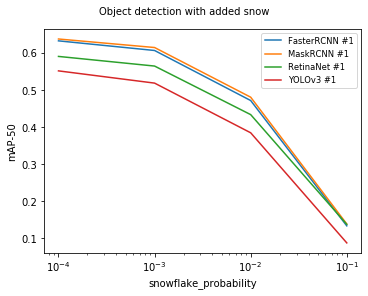

In [10]:
main()

The notebook for this case study can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/case_studies/Object_Detection_Added_Snow.ipynb).